In [30]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels.panel.results import compare

In [31]:
# load the data
df = pd.read_csv('data/data.csv')

# choose time period
df = df[(df.year_month > '2001-12') & (df.year_month < '2022-01')]

## 1. Summary statistics
---

In [32]:
cols = ['RET', 'Co2_tot', 'Intensity_tot', 'Marketcap', 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']
summary_stats1 = df[cols].describe().T[['count','mean', 'std', 'min', '50%', 'max']]
summary_stats1

,count,mean,std,min,50%,max
RET,526393.0,1.304306e-02,1.470043e-01,-0.920559,0.009786,1.625053e+01
Co2_tot,526393.0,5.427269e+06,2.171045e+07,0.267797,401873.632825,4.144484e+08
Intensity_tot,526393.0,4.855482e+02,1.315781e+03,20.431643,148.242032,8.998684e+04
Marketcap,522812.0,3.205875e+05,1.379880e+07,0.007800,3666.730425,9.987323e+08
Levarage,522175.0,6.105285e-01,2.673633e-01,0.000828,0.605880,6.924882e+00
B/M,521618.0,5.206678e+00,9.370803e+02,-4127.449630,0.435844,2.746983e+05
RoE,521900.0,-1.376676e+00,2.159737e+02,-31837.000000,0.100978,3.887000e+02
Inves/AT,520278.0,4.111273e-02,5.345404e-02,-0.185768,0.025440,8.691516e-01
PPE,459439.0,1.059365e+04,3.544350e+04,0.000000,1416.100000,6.351491e+05
SaleGR,467731.0,1.745957e+00,9.670566e+01,-0.999884,0.063214,9.944997e+03


In [33]:
# scale variables
df['Co2_tot'] = np.log(df.Co2_tot + 1)
df['Intensity_tot'] = np.log(df.Intensity_tot + 1)
df['Size'] = np.log(df.Marketcap + 1)
df['PPE'] = np.log(df.PPE + 1)
df['Staff_num'] = np.log(df.Staff_num + 1)
df['Firm_age'] = np.log(df.Firm_age + 1)

In [34]:
cols = ['RET', 'Co2_tot', 'Intensity_tot', 'Size', 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']
summary_stats2 = df[cols].describe().T[['count','mean', 'std', 'min', '50%', 'max']]
summary_stats2

,count,mean,std,min,50%,max
RET,526393.0,0.013043,0.147004,-0.920559,0.009786,16.250530
Co2_tot,526393.0,12.750790,2.663867,0.237281,12.903895,19.842459
Intensity_tot,526393.0,5.184221,1.264155,3.064868,5.005569,11.407430
Size,522812.0,8.208634,1.808897,0.007770,8.207328,20.721997
Levarage,522175.0,0.610529,0.267363,0.000828,0.605880,6.924882
B/M,521618.0,5.206678,937.080257,-4127.449630,0.435844,274698.310539
RoE,521900.0,-1.376676,215.973749,-31837.000000,0.100978,388.700000
Inves/AT,520278.0,0.041113,0.053454,-0.185768,0.025440,0.869152
PPE,459439.0,7.072807,2.421507,0.000000,7.256368,13.361617
SaleGR,467731.0,1.745957,96.705664,-0.999884,0.063214,9944.997181


In [35]:
# there are extrem values in some variables hence we winsorize the df
two_way_winsorize = ['RET', 'B/M', 'RoE', 'SaleGR', 'EPS']
quantiles = df.quantile([0.01, 0.99], numeric_only=True) # calculate quantiles for each column
for col in two_way_winsorize:
  df.loc[(df[col] < quantiles[col].loc[0.01]) | (df[col] > quantiles[col].loc[0.99]), col] = np.nan # replace outliers with np.nan

In [36]:
cols = ['RET', 'Co2_tot', 'Intensity_tot', 'Size', 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']
summary_stats2 = df[cols].describe().T[['count','mean', 'std', 'min', '50%', 'max']]
#summary_stats2.to_latex('summary_stats2.tex', float_format="{:.3f}".format)
summary_stats2

,count,mean,std,min,50%,max
RET,515865.0,0.010639,0.102488,-0.328954,0.009786,0.415272
Co2_tot,526393.0,12.750790,2.663867,0.237281,12.903895,19.842459
Intensity_tot,526393.0,5.184221,1.264155,3.064868,5.005569,11.407430
Size,522812.0,8.208634,1.808897,0.007770,8.207328,20.721997
Levarage,522175.0,0.610529,0.267363,0.000828,0.605880,6.924882
B/M,511184.0,0.528829,0.430547,-0.537490,0.435844,3.005973
RoE,511472.0,0.063646,0.397186,-3.195292,0.100978,2.768128
Inves/AT,520278.0,0.041113,0.053454,-0.185768,0.025440,0.869152
PPE,459439.0,7.072807,2.421507,0.000000,7.256368,13.361617
SaleGR,458396.0,0.104245,0.289537,-0.636089,0.063222,2.596613


In [43]:
#print(pd.concat([summary_stats1, summary_stats2], axis=1).to_latex(float_format="%.2f"))

\begin{tabular}{lccccccccccccc}
\toprule
 & count & mean & std & min & 50% & max & Manipulation & count & mean & std & min & 50% & max \\
\midrule
RET & 526393 & 0.01 & 0.15 & -0.92 & 0.01 & 16.25 & 1\% winsorize & 515865 & 0.01 & 0.10 & -0.33 & 0.01 & 0.42 \\
Co2_tot & 526393 & 5427269.05 & 21710453.29 & 0.27 & 401873.63 & 414448413.32 & Logarithmic & 526393 & 12.75 & 2.66 & 0.24 & 12.90 & 19.84 \\
Intensity_tot & 526393 & 485.55 & 1315.78 & 20.43 & 148.24 & 89986.84 & Logarithmic & 526393 & 5.18 & 1.26 & 3.06 & 5.01 & 11.41 \\
Marketcap(Size) & 522812 & 320587.46 & 13798803.05 & 0.01 & 3666.73 & 998732337.99 & Logarithmic & 522812 & 8.21 & 1.81 & 0.01 & 8.21 & 20.72 \\
Levarage & 522175 & 0.61 & 0.27 & 0 & 0.61 & 6.92 & - & 522175 & 0.61 & 0.27 & 0 & 0.61 & 6.92 \\
B/M & 521618 & 5.21 & 937.08 & -4127.45 & 0.44 & 274698.31 & 1\% winsorize & 511184 & 0.53 & 0.43 & -0.54 & 0.44 & 3.01 \\
RoE & 521900 & -1.38 & 215.97 & -31837 & 0.10 & 388.70 & 1\% winsorize & 511472 & 0.06 & 0.40 & -3.20 & 0.10 & 2.77 \\
Inves/AT & 520278 & 0.04 & 0.05 & -0.19 & 0.03 & 0.87 & - & 520278 & 0.04 & 0.05 & -0.19 & 0.03 & 0.87 \\
PPE & 459439 & 10593.65 & 35443.50 & 0 & 1416.10 & 635149.06 & Logarithmic & 459439 & 7.07 & 2.42 & 0 & 7.26 & 13.36 \\
SaleGR & 467731 & 1.75 & 96.71 & -1 & 0.06 & 9945 & 1\% winsorize & 458396 & 0.10 & 0.29 & -0.64 & 0.06 & 2.60 \\
EPS & 522856 & 5.75 & 151.89 & -998.26 & 1.44 & 8548 & 1\% winsorize & 512453 & 1.75 & 3.02 & -9.78 & 1.44 & 18.27 \\
Staff_num & 515253 & 26.59 & 72.31 & 0 & 6.10 & 2300 & Logarithmic & 515253 & 2.11 & 1.49 & 0 & 1.96 & 7.74 \\
Firm_age & 513763 & 70.56 & 52.56 & 2 & 54 & 657 & Logarithmic & 513763 & 3.99 & 0.79 & 1.10 & 4.01 & 6.49 \\
\bottomrule
\end{tabular}

In [39]:
# compute the pearson corr among each variables, with statistic significance

# define a function to compute the correlation 
from scipy.stats import pearsonr
def correlation_(df):
  rho = df.corr()
  pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
  p = pval.map(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
  tab = rho.round(2).astype(str) + p
  for i in range(0,tab.shape[1]):
    for j in range(0,tab.shape[1]):
      if i>j:
        tab.iloc[i,j] = ''
  return tab

tab = correlation_(df[['Co2_tot', 'Intensity_tot', 'Size', 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])
tab

,Co2_tot,Intensity_tot,Size,Levarage,B/M,RoE,Inves/AT,PPE,SaleGR,EPS,Staff_num,Firm_age
Co2_tot,1.0***,0.63***,0.66***,0.09***,0.02***,0.22***,0.24***,0.85***,-0.1***,0.3***,0.72***,0.38***
Intensity_tot,,1.0***,0.08***,-0.13***,-0.0**,0.01***,0.37***,0.44***,-0.04***,-0.0,0.13***,0.1***
Size,,,1.0***,0.02***,-0.21***,0.23***,0.05***,0.68***,0.01***,0.39***,0.69***,0.3***
Levarage,,,,1.0***,-0.06***,0.06***,-0.08***,0.18***,-0.09***,0.03***,0.15***,0.2***
B/M,,,,,1.0***,-0.09***,-0.04***,0.11***,-0.12***,-0.06***,-0.05***,0.04***
RoE,,,,,,1.0***,0.03***,0.18***,0.03***,0.39***,0.19***,0.17***
Inves/AT,,,,,,,1.0***,0.33***,0.07***,0.01***,0.05***,-0.04***
PPE,,,,,,,,1.0***,-0.13***,0.27***,0.71***,0.39***
SaleGR,,,,,,,,,1.0***,0.05***,-0.11***,-0.16***
EPS,,,,,,,,,,1.0***,0.29***,0.25***


In [42]:
#print(tab.to_latex())

## 2. Regression analysis
---
### 2.1 Base line models

In [7]:
# model with industry + time F.E.
# un restricted model
data = df[['PERMNO', 'year_month', 'year', 'industry', 'RET', 'Co2_tot']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)

dependent = data.RET
exog = sm.add_constant(data['Co2_tot'])

model1 = PanelOLS(dependent, exog, entity_effects=False, time_effects=True, other_effects=data['industry'])
fit1 = model1.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['industry', 'year_month']], low_memory=True)

# restricted model
data = df[['PERMNO', 'year_month', 'year', 'industry', 'RET', 'Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)

dependent = data.RET
exog = sm.add_constant(data[['Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])

model2 = PanelOLS(dependent, exog, entity_effects=False, time_effects=True, other_effects=data['industry'])
fit2 = model2.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['industry', 'year_month']], low_memory=True)

In [8]:
# model with firm + time F.E.
# un restricted model
data = df[['PERMNO', 'year_month', 'year', 'industry', 'RET', 'Co2_tot']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)

dependent = data.RET
exog = sm.add_constant(data['Co2_tot'])

model3 = PanelOLS(dependent, exog, entity_effects=True, time_effects=True, other_effects=None)
fit3 = model3.fit(cov_type='clustered', cluster_entity=True, cluster_time=True, clusters=None, low_memory=True)

# restricted model
data = df[['PERMNO', 'year_month', 'year', 'industry', 'RET', 'Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)

dependent = data.RET
exog = sm.add_constant(data[['Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])

model4 = PanelOLS(dependent, exog, entity_effects=True, time_effects=True, other_effects=None)
fit4 = model4.fit(cov_type='clustered', cluster_entity=True, cluster_time=True, clusters=None, low_memory=True)

In [9]:
from io import StringIO
import warnings

def compare_df(x, fit_stats=['Estimator', 'R-squared', 'No. Observations']):
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        y = pd.read_csv(StringIO(compare(x, stars=True, precision='std_errors').summary.as_csv()), skiprows=1, skipfooter=1, engine='python')
    z = pd.DataFrame(
        data=y.iloc[:, 1:].values,
        index=y.iloc[:, 0].str.strip(),
        columns=pd.MultiIndex.from_arrays(
            arrays=[y.columns[1:], y.iloc[0][1:]],
            names=['Model', 'Dep. Var.']
        )
    )
    return pd.concat([z.iloc[11:], z.loc[fit_stats]])

In [10]:
#compare_df([fit1, fit2, fit3, fit4])
print(compare_df([fit1, fit2, fit3, fit4]).to_latex())

\begin{tabular}{lllll}
\toprule
Model &          Model 0          &          Model 1          &    Model 2    &    Model 3     \\
Dep. Var. & RET                       & RET                       & RET           & RET            \\
                        &  &  &  &  \\
\midrule
const & -0.0726                   & 0.4292                    & 3.5498***     & 0.2174         \\
 & (0.4904)                  & (0.6257)                  & (1.0448)      & (2.8308)       \\
Co2_tot & 0.0889**                  & 0.0099                    & -0.1945**     & -0.6997***     \\
 & (0.0388)                  & (0.0533)                  & (0.0818)      & (0.1154)       \\
Size &                           & 0.3172***                 &               & 1.6487***      \\
 &                           & (0.1007)                  &               & (0.1916)       \\
Levarage &                           & -0.2422                   &               & 0.3389         \\
 &                           & (0.1942)      

### 2.2 Change Fixed effects and cluster standard errors

In [11]:
data = df[['PERMNO', 'year_month', 'year', 'industry', 'RET', 'Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)

dependent = data.RET
exog = sm.add_constant(data[['Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])

# 1. benchmark model
model1 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['PERMNO', 'year_month']])
fit1 = model1.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['PERMNO', 'year_month']], low_memory=True)

# 2. only entity fixed effects
model2 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['PERMNO']])
fit2 = model2.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['PERMNO']], low_memory=True)

# 3. entity + year fixed effects
model3 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['PERMNO', 'year']])
fit3 = model3.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['PERMNO', 'year']], low_memory=True)

# 4. industry fixed effects
model4 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data['industry'])
fit4 = model4.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data['industry'], low_memory=True)

# 5. industry + year_month fixed effects
model5 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['industry', 'year_month']])
fit5 = model5.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['industry', 'year_month']], low_memory=True)

# 6. industry + year fixed effects
model6 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['industry', 'year']])
fit6 = model6.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['industry', 'year']], low_memory=True)

#########################################################
# 7. benchmark model + robust standard errors
model7 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['PERMNO', 'year_month']])
fit7 = model7.fit()

# 8. benchmark model + cluster higher level 
model8 = PanelOLS(dependent, exog, entity_effects=False, time_effects=False, other_effects=data[['PERMNO', 'year_month']])
fit8 = model8.fit(cov_type='clustered', cluster_entity=False, cluster_time=False, clusters=data[['industry', 'year']], low_memory=True)

In [12]:
results = []  # Initialize an empty list named 'results'

# Append the regression results strings to the 'results' list
results.append(fit1)
results.append(fit2)
results.append(fit3)
results.append(fit4)
results.append(fit5)
results.append(fit6)
results.append(fit7)
results.append(fit8)

In [13]:
temp = pd.DataFrame({'r': [results[i].params['Co2_tot'] for i in range(0,8)],
                    'p-val': [round(results[i].pvalues['Co2_tot'], 3) for i in range(0,8)],
                    'hl': [results[i].conf_int().iloc[1,1] for i in range(0,8)],
                    'll': [results[i].conf_int().iloc[1,0] for i in range(0,8)],
                    'std': [round(results[i].std_errors['Co2_tot'],3) for i in range(0,8)],
                    'power': [round(results[i].rsquared, 3) for i in range(0,8)],
                    'label': ['1. Benchmark model', '2. Entity F.E.', '3. Entity + Year F.E.', '4. Industry F.E.', '5. Industry + Year/Mon F.E.', '6. Industry +  Year F.E.', '7. Robust Standard Errors', '8. Industry + Year'],
                    'var': ['1. Benchmark model', '2. Entity F.E.', '3. Entity + Year F.E.', '4. Industry F.E.', '5. Industry + Year/Mon F.E.', '6. Industry +  Year F.E.', '7. Robust Standard Errors', '8. Industry + Year'],
                    'group': ['Benchmark', 'Fixed effects', 'Fixed effects', 'Fixed effects', 'Fixed effects', 'Fixed effects', 'Clustered standard errors', 'Clustered standard errors'],
                    'n': [(results[i].nobs) for i in range(0,8)]})

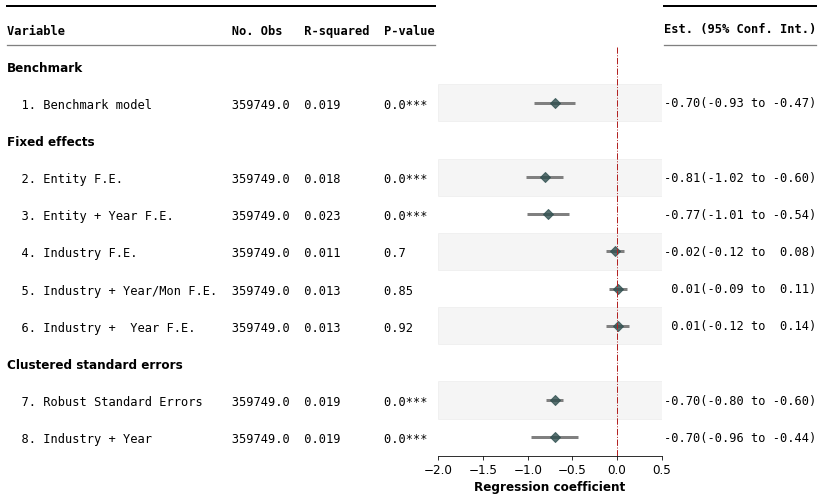

In [25]:
import forestplot as fp
import matplotlib.pyplot as plt

fp.forestplot(temp,  # the dataframe with results data
              estimate="r",  # col containing estimated effect size 
              ll="ll", hl="hl",  # lower & higher limits of conf. int.
              varlabel="label",  # column containing the varlabels to be printed on far left
              pval="p-val",  # column containing p-values to be formatted
              annote=['n', 'power', "formatted_pval"],  # columns to report on left of plot
              annoteheaders=['No. Obs', 'R-squared', "P-value"],  # ^corresponding headers
              rightannote=["est_ci"],  # columns to report on right of plot 
              right_annoteheaders=["Est. (95% Conf. Int.)"],  # ^corresponding headers
              groupvar="group",  # column containing group labels
              group_order=["Benchmark", "Fixed effects", "Clustered standard errors"],                   
              xlabel="Regression coefficient",  # x-label title
              xticks=[-2, -1.5, -1, -0.5, 0, 0.5],  # x-ticks to be printed
              sort=False,  # sort estimates in ascending order
              color_alt_rows=True,  # Gray alternate rows
              table=True,  # Format as a table
              figsize=(4, 8),
              # Additional kwargs for customizations
              **{'fontfamily': 'monospace', # only font that align
                 "marker": "D",
                 "markersize": 50,  # adjust marker size
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "firebrick",  # color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                 'linecolor': 'gray', # error bar line color
                 'lw': 3, # error bar line width
                 'xlinestyle': 'dashdot', # vertical line change
                 'xlinewidth': 1
                }
              )

#plt.tight_layout()  # Adjust subplot layout for better spacing
# Specify high resolution (dpi) when saving the figure using Matplotlib's savefig
plt.savefig("graphics/forestplot.png", bbox_inches="tight", dpi=300)

### 2.3 Interplay with climate concerns

In [26]:
# construct UMC
index_ = pd.read_csv('data/raw_data/index.csv')
index_['year_month'] = pd.PeriodIndex(index_.year_month, freq='M').astype(str)

# shift columns
col_shift = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'sent', 'wti', 'CFNAI', 'vix']
index_[col_shift] = index_[col_shift].shift(1)

index_['mccc_lag1'] = index_.mccc.shift(1)

# drop nas
index_.dropna(inplace=True)

# use ARC model to get umc
arx_model = sm.OLS.from_formula('mccc ~ 1 + mccc_lag1 + Mkt_RF + SMB + HML + RMW + CMA + sent + wti + CFNAI + vix', data=index_)
arx_fit = arx_model.fit()

index_['umc'] = index_.mccc - arx_fit.predict()

index_ = index_[['year_month', 'umc']]

In [27]:
# merge with UMC data
df = df.merge(index_, how='left')

# load data
index_all = pd.read_csv('data/raw_data/index.csv')
index_all['year_month'] = pd.PeriodIndex(index_all.year_month, freq='M').astype(str)

# merge data
df = pd.merge(df, index_all, how='inner')

In [28]:
# with market factor model
data = df[['PERMNO', 'year_month', 'year', 'RET', 'umc', 'Mkt_RF', 'Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)
data['intersection'] = data.Co2_tot * data.umc

dependent = data.RET
exog = sm.add_constant(data[['Co2_tot', 'umc', 'intersection', 'Mkt_RF', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])

model1 = PanelOLS(dependent, exog, entity_effects=True, time_effects=False)
fit1 = model1.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)

# with FF 3 factors model
data = df[['PERMNO', 'year_month', 'year', 'RET', 'umc', 'Mkt_RF', 'SMB', 'HML', 'Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)
data['intersection'] = data.Co2_tot * data.umc

dependent = data.RET
exog = sm.add_constant(data[['Co2_tot', 'umc', 'intersection', 'Mkt_RF', 'SMB', 'HML', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])

model2 = PanelOLS(dependent, exog, entity_effects=True, time_effects=False)
fit2 = model2.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)

# with FF 5 factors model
data = df[['PERMNO', 'year_month', 'year', 'RET', 'umc', 'Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)
data['intersection'] = data.Co2_tot * data.umc

dependent = data.RET
exog = sm.add_constant(data[['Co2_tot', 'umc', 'intersection', 'Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])

model3 = PanelOLS(dependent, exog, entity_effects=True, time_effects=False)
fit3 = model3.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)

# with FF 5 factors and other indicators
data = df[['PERMNO', 'year_month', 'year', 'RET', 'umc', 'Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'sent', 'wti', 'CFNAI', 'vix', 'Co2_tot', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].dropna()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
data = data.set_index(['PERMNO', 'year_month'], drop=False)
data['intersection'] = data.Co2_tot * data.umc

dependent = data.RET
exog = sm.add_constant(data[['Co2_tot', 'umc', 'intersection', 'Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'sent', 'wti', 'CFNAI', 'vix', 'Size' , 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])

model4 = PanelOLS(dependent, exog, entity_effects=True, time_effects=False)
fit4 = model4.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)

In [29]:
#compare_df([fit1, fit2, fit3, fit4])
print(compare_df([fit1, fit2, fit3, fit4]).to_latex())

\begin{tabular}{lllll}
\toprule
Model &    Model 0     &    Model 1     &    Model 2     &    Model 3     \\
Dep. Var. & RET            & RET            & RET            & RET            \\
                        &  &  &  &  \\
\midrule
const & 3.6034*        & 3.1348         & 2.9799         & 1.6333         \\
 & (2.0580)       & (2.0850)       & (2.1187)       & (2.2968)       \\
Co2_tot & -0.6228***     & -0.6284***     & -0.6282***     & -0.6304***     \\
 & (0.1009)       & (0.0981)       & (0.0984)       & (0.1003)       \\
umc & 1.5875***      & 1.6178***      & 1.3719***      & 1.6593***      \\
 & (0.3697)       & (0.3690)       & (0.3709)       & (0.3725)       \\
intersection & -0.1307***     & -0.1401***     & -0.1271***     & -0.1445***     \\
 & (0.0266)       & (0.0266)       & (0.0266)       & (0.0268)       \\
Mkt_RF & 1.0192***      & 0.9246***      & 0.9307***      & 0.9635***      \\
 & (0.0089)       & (0.0078)       & (0.0076)       & (0.0085)       \\
Size & 1.